In [1]:
import numpy as np
import scipy.io as sio
from scipy import signal
from scipy.signal import butter, lfilter, iirnotch
from brainflow.board_shim import BoardShim, BrainFlowInputParams, BoardIds
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import cross_val_score, StratifiedKFold

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from mne.decoding import CSP  # CSP implementation in MNE
from sklearn.metrics import accuracy_score

In [2]:
def butter_filter(data, cutoff, fs, btype='low', order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype=btype, analog=False)
    y = lfilter(b, a, data, axis=0)
    return y

def notch_filter(signal, fs, freq=60, Q=30):
    b, a = iirnotch(freq, Q, fs)
    return lfilter(b, a, signal, axis=0)

In [3]:
debug = False

# Setting up the board
if debug:
    # Create a synthetic board for debugging purposes
    board_id = BoardIds.SYNTHETIC_BOARD
    params = BrainFlowInputParams()
else:
    # Setting up the board
    params = BrainFlowInputParams()
    params.serial_number = 'UN-2023.02.30'
    board_id = BoardIds.UNICORN_BOARD
    
board = BoardShim(board_id, params)

# Getting specific board details
channels = board.get_eeg_channels(board_id) #EEG Channels
timestamp_channel = board.get_timestamp_channel(board_id) # Timestamp channel
marker_channel = board.get_marker_channel(board_id) # Marker channel for synchronization
sampling_rate = BoardShim.get_sampling_rate(board_id) # Hz

In [4]:
dataset = np.loadtxt(r"..//dataset3.csv", delimiter=",")

In [5]:
eegdata = dataset[:, channels]
markers = dataset[:, marker_channel]

In [6]:
# Getting markers
idx_starting_markers = np.arange(0, len(markers))
idx_starting_markers = idx_starting_markers[markers != 0]
idx_starting_markers = idx_starting_markers[markers[idx_starting_markers] != 67]

idx_end_markers = np.arange(0, len(markers))[markers == 67]

# Preprocessing EEG
start = idx_end_markers[0]
idx_end_markers = idx_end_markers[1:]

raw_label = np.zeros_like(markers)

# Set label outputs to constant
for i in range(len(idx_starting_markers)):
    marker = markers[idx_starting_markers[i]]
    raw_label[idx_starting_markers[i]:idx_end_markers[i]] = marker

good_eeg = eegdata[start:, :]
good_label = raw_label[start:]

In [7]:
step = 125
window_size = int(4*sampling_rate)
buffer = 400
windows = []
labels = []


i=0
while i <  len(good_label) - window_size - buffer:
    temp_emg = good_eeg[ i:i+window_size+buffer, : ]

    # Preprocess EMG
    temp_emg = butter_filter(temp_emg, 3, sampling_rate, btype='high', order=2)
    temp_emg = butter_filter(temp_emg, 80, sampling_rate, btype='low', order=2)
    temp_emg = notch_filter(temp_emg, sampling_rate, freq=60)

    temp_emg = temp_emg[buffer:, :]
    temp_emg -= np.mean(temp_emg, axis=1, keepdims=True)

    temp_mean = np.mean(temp_emg, axis=0, keepdims=True)
    temp_std = np.mean(temp_emg, axis=0, keepdims=True)

    temp_emg = (temp_emg - temp_mean) / temp_std

    windows.append(temp_emg)

    # Preprocess
    temp_label = good_label[i+window_size+buffer-125]
    labels.append(temp_label)
    i += step


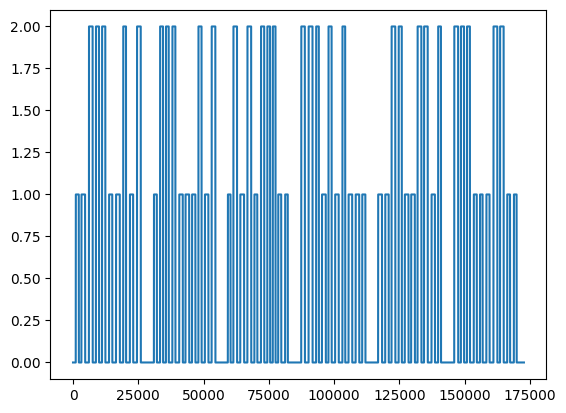

In [8]:
plt.plot(good_label)

In [9]:
windows = np.array(windows)
labels = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(
    windows, labels, test_size=0.3, shuffle=False
)

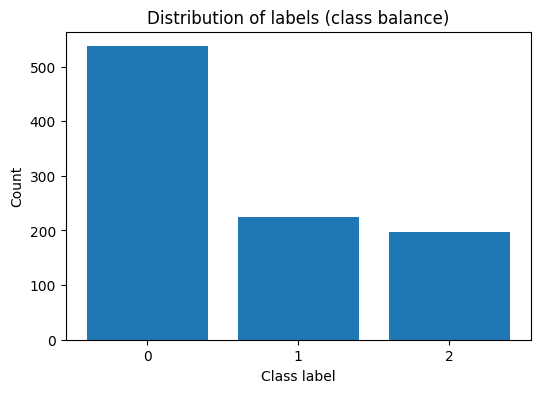

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Example: labels array
# labels = np.array([...])

plt.figure(figsize=(6,4))
plt.hist(y_train, bins=np.arange(y_train.min(), y_train.max()+2)-0.5, rwidth=0.8)
plt.xticks(np.unique(labels))
plt.xlabel("Class label")
plt.ylabel("Count")
plt.title("Distribution of labels (class balance)")
plt.show()

In [11]:
from sklearn.utils import resample

def random_undersample(X, y, random_state=0):
    """
    Undersample majority classes to match the minority class count.
    X: (N, channels, times)
    y: (N,)
    Returns X_res, y_res
    """
    classes, counts = np.unique(y, return_counts=True)
    min_count = counts.min()

    keep_idx = []
    for cls in classes:
        idx_cls = np.where(y == cls)[0]
        if len(idx_cls) <= min_count:
            keep = idx_cls
        else:
            keep = resample(idx_cls, replace=False, n_samples=min_count, random_state=random_state)
        keep_idx.append(keep)

    keep_idx = np.concatenate(keep_idx)
    # optionally shuffle the result
    rng = np.random.RandomState(random_state)
    rng.shuffle(keep_idx)

    return X[keep_idx], y[keep_idx]


X_train, y_train = random_undersample(X_train, y_train)

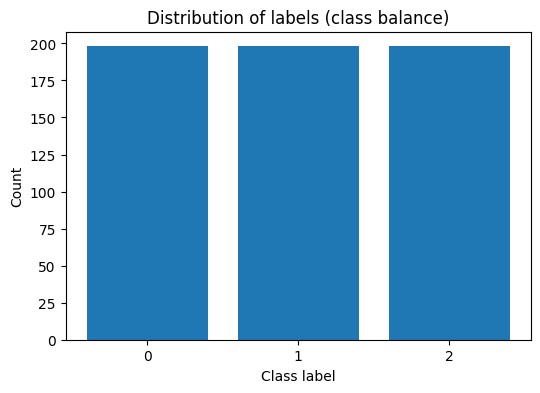

In [12]:
plt.figure(figsize=(6,4))
plt.hist(y_train, bins=np.arange(y_train.min(), y_train.max()+2)-0.5, rwidth=0.8)
plt.xticks(np.unique(labels))
plt.xlabel("Class label")
plt.ylabel("Count")
plt.title("Distribution of labels (class balance)")
plt.show()

In [13]:
# Precompute trial covariances (shape: n_trials, n_channels, n_channels)
covs = np.array([np.cov(trial) for trial in X_train])

# CSP can fit directly on covariances
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)
csp.fit(covs, y_train)

X_train_csp = csp.transform(X_train)
X_test_csp = csp.transform(X_test)

lda = LDA(solver="lsqr", shrinkage="auto")
lda.fit(X_train_csp, y_train)
y_test_pred = lda.predict(X_test_csp)

print("Test acc:", accuracy_score(y_test, y_test_pred))

Computing rank from data with rank=None
    Using tolerance 6.3e+12 (2.2e-16 eps * 1000 dim * 2.9e+25  max singular value)
    Estimated rank (data): 999
    data: rank 999 computed from 1000 data channels with 0 projectors
    Setting small data eigenvalues to zero (without PCA)
Reducing data rank from 1000 -> 999
Estimating class=0.0 covariance using EMPIRICAL
Done.
Estimating class=1.0 covariance using EMPIRICAL
Done.
Estimating class=2.0 covariance using EMPIRICAL
Done.


c:\Users\kapj_\AppData\Local\Programs\Python\Python310\lib\site-packages\mne\decoding\csp.py:773: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
c:\Users\kapj_\AppData\Local\Programs\Python\Python310\lib\site-packages\mne\decoding\csp.py:775: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)
c:\Users\kapj_\AppData\Local\Programs\Python\Python310\lib\site-packages\mne\decoding\csp.py:785: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.real(tmp + np.sqrt(tmp**2 - h12 * h21))


ValueError: array must not contain infs or NaNs

In [ ]:
len(X_test)

In [ ]:
X_test[0].shape

print(clf.predict(np.expand_dims(X_test[7], axis=0)))
print(y_test[7])